### Extract text from Pdf documents and apply NER

In [1]:
import pdfplumber, os
import os.path as osp
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from pdf_extract.services import file
from pdf_extract.config import global_config as glob
from pdf_extract.config import config
from pdf_extract.utils import utils
from importlib import reload
import fasttext

reload(glob)
reload(config)
reload(utils)
reload(file);

In [2]:
list_of_NEG_docs = os.listdir(osp.join(glob.UC_DATA_DIR, 'example_cvs', 'negatives'))
n_neg = len(list_of_NEG_docs)

list_of_POS_docs = os.listdir(osp.join(glob.UC_DATA_DIR, 'example_cvs', 'positives'))
n_pos = len(list_of_POS_docs)

print(n_pos)
print(n_neg)

13
15


Read in all Pdfs in directory:

Postives only:

In [3]:
raw_corpus1 = pd.DataFrame(columns=['text', 'fname'])

for z, fname in enumerate(list_of_POS_docs):
    i, page_objects, text = 0, {}, ""
    # The open method returns an instance of the pdfplumber.PDF class.
    with pdfplumber.open(osp.join(glob.UC_DATA_DIR, "example_cvs",f"positives/{fname}")) as pdf:
        while i < len(pdf.pages):
            page = pdf.pages[i]
            #print(pdf.metadata)
            page_objects[str(i+1)] = page.extract_text(x_tolerance=1, y_tolerance=3) #.split('\n')
            text += page_objects[str(i+1)]
            #print(f"Page {i}")
            #print(page.extract_text())
            i += 1
    
    raw_corpus1.loc[z] = [text,fname]  
raw_corpus1['label'] = 'positive'

Negatives only:

In [4]:
raw_corpus2 = pd.DataFrame(columns=['text', 'fname'])

for z, fname in enumerate(list_of_NEG_docs):
    i, page_objects, text = 0, {}, ""
    # The open method returns an instance of the pdfplumber.PDF class.
    with pdfplumber.open(osp.join(glob.UC_DATA_DIR, "example_cvs",f"negatives/{fname}")) as pdf:
        while i < len(pdf.pages):
            page = pdf.pages[i]
            page_objects[str(i+1)] = page.extract_text(x_tolerance=1, y_tolerance=3) #.split('\n')
            text += page_objects[str(i+1)]
            i += 1
    
    raw_corpus2.loc[z] = [text,fname]   
raw_corpus2['label'] = 'negative'

In [5]:
raw_corpus = pd.concat([raw_corpus1,raw_corpus2], axis=0, ignore_index=True)
#raw_corpus

In [6]:
#page_objects
#page.extract_words()

In [7]:
#page_instance = page_objects['1']

In [8]:
#pdf.metadata
#page_instance

(19, 3)
(9, 3)


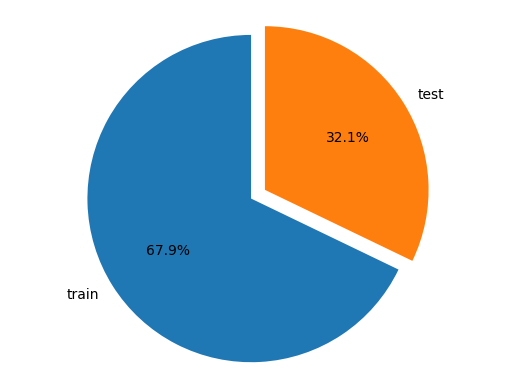

In [9]:
from sklearn.model_selection import train_test_split

reload(utils)

#X_train, X_valid, X_test, y_train, y_valid, y_test = utils.train_test_split_extend(X['text_cleaned'], y=X['label'], test_size=[0.2, 0.2], random_state=42, shuffle=True)
X_train, X_test, y_train, y_test = utils.train_test_split_extend(raw_corpus, y=raw_corpus['label'], test_size=[0.3], random_state=42, shuffle=True)

print(X_train.shape)
#print(y_train.shape)
print(X_test.shape)
#print(X_valid.shape)

# Plot split:
#-------------
sizes = [len(X_train.index), len(X_test.index)]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=(0.1, 0), labels=['train', 'test'] , autopct='%1.1f%%', startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle.
ax1.axis('equal')
plt.show()


Preprocess corpus:

In [10]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer #, TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from pdf_extract.resources import preprocessor as preproc

reload(preproc)

# Preprocess corpus:
cleaner = preproc.clean_text(language='english', lemma = False, stem = True)

# Full sample
X_cleaned = cleaner.fit_transform(raw_corpus['text'])      

# Train
X_train_cleaned = cleaner.fit_transform(X_train['text'])

file.PickleService(path="trained_text_preproc.pkl", root_path=glob.UC_DATA_DIR, is_df=False, verbose=False).doWrite(cleaner)

# Test
X_test_cleaned = cleaner.transform(X_test['text'])


[nltk_data] Downloading package punkt to /home/alexv84/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alexv84/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/alexv84/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alexv84/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Using english language.
Using 179 stop words.
Added 8 stopword(s).
Added 13 stopword(s).
Adding custom stop words...
Loading nltk stemmer.
Setting to lower cases.
Removing whitespaces.
Applying word tokenizer.
Removing custom stopwords.
Removing punctuations.
Removing numbers.
Removing digits.
Removing non-alphabetic characters.
Removing short tokens.
Applying stemming.
Finished preprocessing!
Setting to lower cases.
Removing whitespaces.
Applying word tokenizer.
Removing custom stopwords.
Removing punctuations.
Removing numbers.
Removing digits.
Removing non-alphabetic characters.
Removing short tokens.
Applying stemming.
Finished preprocessing!
Setting to lower cases.
Removing whitespaces.
Applying word tokenizer.
Removing custom stopwords.
Removing punctuations.
Removing numbers.
Removing digits.
Removing non-alphabetic characters.
Removing short tokens.
Applying stemming.
Finished preprocessing!


Train model:

In [11]:
reload(preproc)

parameters = {
    'vectorizer__max_df': (0.5, 0.75, 1.0),
     'vectorizer__max_features': (None, 500, 1000, 5000, 10000),
   #   'vectorizer__analyzer' : ("word", "char", "char_wb"),
    'vectorizer__ngram_range': ((1, 1), (1, 2), (1, 3), (1, 4), (2, 2))  
    #'vectorizer__ngram_range': ((1,1), (1, 2), (1, 3), (2, 3), (3, 3), (3, 5))  
}


pipeline = Pipeline([
   # ('cleaner', preproc.clean_text(language='english', lemma = False, stem = False)),
#    ('vectorizer', CountVectorizer(lowercase=True, 
#                        #token_pattern = '(?u)(?:(?!\d)\w)+\\w+', 
#                        #analyzer = 'char_wb', 
#                        tokenizer = None, stop_words = None)), 
    ('vectorizer', TfidfVectorizer(lowercase=True, norm="l2",
                       #token_pattern = '(?u)(?:(?!\d)\w)+\\w+', 
                       analyzer = 'word',   # char_wb 
                    #    ngram_range=(1,3),
                       tokenizer = None, stop_words = None)), 
   ('model', MultinomialNB())
])

# trained = pipeline.fit(X_train_cleaned, y_train)

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

gs = grid_search.fit(X_train_cleaned, y_train)

best_parameters = grid_search.best_estimator_.get_params()

#print(best_parameters)

# best_model refit:
trained = grid_search.best_estimator_


Fitting 5 folds for each of 75 candidates, totalling 375 fits


[nltk_data] Downloading package punkt to /home/alexv84/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alexv84/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
#-------------
# Save model:
#-------------
file.PickleService(path="trained_model.pkl", root_path=glob.UC_DATA_DIR, is_df=False, verbose=False).doWrite(X=trained)


In [13]:
trained = file.PickleService(path="trained_model.pkl", root_path=glob.UC_DATA_DIR, is_df=False, verbose=False).doRead()

In [14]:
# Predict:
y_pred_train = trained.predict(X_train_cleaned)

#print(confusion_matrix(test_set['label'], y_pred))
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00        10
    positive       1.00      1.00      1.00         9

    accuracy                           1.00        19
   macro avg       1.00      1.00      1.00        19
weighted avg       1.00      1.00      1.00        19



In [15]:
# Predict:
y_pred_test = trained.predict(X_test_cleaned)

print(confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

[[3 2]
 [1 3]]
              precision    recall  f1-score   support

    negative       0.75      0.60      0.67         5
    positive       0.60      0.75      0.67         4

    accuracy                           0.67         9
   macro avg       0.68      0.68      0.67         9
weighted avg       0.68      0.67      0.67         9



Use full corpus and estimate F1 controlling for train/test uncertainty:

In [16]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(trained, X_cleaned, raw_corpus['label'], cv=5, scoring='f1_macro')

print(scores)
print("%0.2f F1 with standard deviation %0.2f" % (scores.mean(), scores.std()))

[0.625      0.82857143 0.625      0.8        0.76190476]
0.73 F1 with standard deviation 0.09


In [17]:
X_test['Prob. positive class'] = trained.predict_proba(X_test_cleaned)[:,1]
X_train['Prob. positive class'] = trained.predict_proba(X_train_cleaned)[:,1]

In [18]:
#X_train.sort_values(by = 'Prob. positive class', ascending=False)

In [19]:
tfidf = pipeline.named_steps['vectorizer']

X_doc_term = tfidf.fit_transform(X_train_cleaned).toarray()

print(X_doc_term.shape)         #doc-terms
print(len(tfidf.get_feature_names_out()))        # terms

# for i in tfidf.get_feature_names_out():
#      print(i)

#tfidf.vocabulary_

(19, 2325)
2325


### Individually explain predictions on test set:

In [20]:
from lime.lime_text import LimeTextExplainer

class_names = ['negative', 'positive']
explainer = LimeTextExplainer(class_names = class_names)

idx = 2
exp = explainer.explain_instance(X_test_cleaned.iloc[idx], trained.predict_proba, num_features=5)

In [21]:
print('Document id: %d' % X_test_cleaned.index[idx])
print(f"Documnet name: {X_test['fname'].iloc[idx]}")
print('Probability("positive") =', trained.predict_proba(X_test_cleaned.to_frame().iloc[idx])[:,1][0])
print('True class: %s' % y_test.iloc[idx])

Document id: 12
Documnet name: cv21.pdf
Probability("positive") = 0.6535903138646869
True class: positive


In [22]:
#X_test.sort_values(by = 'Prob. positive class', ascending=False)

In [23]:
# Weighted features for linear surrogate model, which approximates the behaviour of the orig. classifier in the vicinity of the test example.
#exp.as_list()

In [24]:
%matplotlib inline

#fig = exp.as_pyplot_figure()

In [25]:
#exp.show_in_notebook(text=True)

In [26]:
#exp.save_to_file('/tmp/oi.html')      # save the fully contained html page to a file

In [27]:
#from lime import submodular_pick

#sp_obj = submodular_pick.SubmodularPick(explainer, X_test_cleaned.iloc[idx], trained.predict_proba, sample_size=2, num_features=5,num_exps_desired=2)


### Globally explain model predictions: 

In [28]:
from sklearn.preprocessing import StandardScaler

X_sc = StandardScaler().fit_transform(X_doc_term)  # use train set doc-term matrix from tf-idf as design matrix

lr = LogisticRegression(max_iter=50, C=0.3).fit(X_sc, y_pred_train)

#print(lr.coef_)     # feature importances by absolute value

In [29]:
# Take absolute values and sort in descending order:
abs_lr_weights = pd.DataFrame(np.abs(lr.coef_)).T.set_index(tfidf.get_feature_names_out()).sort_values(by=0, ascending=False)
#abs_lr_weights.head(6)

In [30]:
# lr_weights = pd.DataFrame(lr.coef_).T.set_index(tfidf.get_feature_names_out()).sort_values(by=0, ascending=False)
# lr_weights.head(6)

Test POST request:

In [31]:
from pdf_extract.config import global_config as glob
from pdf_extract.services import pipelines as trained_pipelines
from importlib import reload

reload(trained_pipelines)

trained_pipelines.pipe.predict_proba(X_test['text'])

#X_test['text']

Setting to lower cases.
Removing whitespaces.
Applying word tokenizer.
Removing custom stopwords.
Removing punctuations.
Removing numbers.
Removing digits.
Removing non-alphabetic characters.
Removing short tokens.
Applying stemming.
Finished preprocessing!


array([[0.36513074, 0.63486926],
       [0.51568666, 0.48431334],
       [0.34640969, 0.65359031],
       [0.22809017, 0.77190983],
       [0.4106264 , 0.5893736 ],
       [0.56779084, 0.43220916],
       [0.7417511 , 0.2582489 ],
       [0.56845905, 0.43154095],
       [0.34817081, 0.65182919]])

In [32]:
#X_test['Prob. positive class']

In [78]:
list_of_docs = os.listdir(osp.join(glob.UC_DATA_DIR,'example_cvs/rest_queries'))
list_of_docs


['cv9.pdf', 'cv21.pdf']

In [79]:
fname = list_of_docs[0]

#query = pd.DataFrame(columns=['text', 'fname'])
query = []
for z, fname in enumerate(list_of_docs):
    text = file.PDFService(path=f'example_cvs/rest_queries/{fname}', verbose=False).doRead()
    #query.loc[z] = [text,fname]
    query.append(text)

In [95]:
payload = query['text'].tolist()
#payload = text
#payload